In [1]:
# Dependencies
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
# from sodapy import Socrata
from config import census_key
import pprint
import requests

In [2]:
# Function for quickly assempling a DataFrame
def json_to_dataframe(response):
    return pd.DataFrame(response.json()[1:], columns=response.json()[0])

In [3]:
# CDC DataFrame by county in Minnesota
cdc_data = pd.read_csv("../Project_1/cdc_data.csv")

cdc_df = pd.DataFrame(cdc_data)
cdc_df.columns
cdc_df = cdc_df[['case_month', 'res_state', 'res_county', 'age_group', 'sex', 'race', 'ethnicity', 'current_status']]
cdc_df = cdc_df.rename(columns={
    'case_month': 'Year-Month',
    'res_state': 'State',
    'res_county': 'County',
    'age_group': 'Age Group',
    'race': 'Race',
    'sex': 'Sex',
    'ethnicity': 'Ethnicity',
    'current_status': 'Infection Status'
})
# Drop "Unkown" race from dataset
cdc_df = cdc_df.loc[cdc_df['Race']!= 'Unknown',:]
cdc_df.head()

,Year-Month,State,County,Age Group,Sex,Race,Ethnicity,Infection Status
0,2021-11,MN,STEELE,18 to 49 years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case
2,2021-11,MN,STEARNS,50 to 64 years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case
3,2020-05,MN,KANDIYOHI,18 to 49 years,Male,White,Non-Hispanic/Latino,Laboratory-confirmed case
4,2021-05,MN,ANOKA,18 to 49 years,Male,NaN,NaN,Laboratory-confirmed case
5,2020-04,MN,CLAY,65+ years,Female,White,Non-Hispanic/Latino,Laboratory-confirmed case


In [4]:
# Poverty DataFrame By Race - 2020

url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B17001_002E,B17001A_002E,B17001B_002E,B17001C_002E,B17001D_002E,B17001E_002E,B17001F_002E,B17001G_002E,B17001H_002E,B17001I_002E&for=county:*&in=state:27&key={0}".format(census_key)
response = requests.request("GET", url)
response
poverty_df = json_to_dataframe(response)

# Split NAME into county & state
name = poverty_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = poverty_df['County']=name[0]
STATE = poverty_df['State']=name[1]
poverty_df.drop(columns=["NAME"], inplace=True)
poverty_df['Caucasian2'] = poverty_df['B17001A_002E'].astype(int) - poverty_df['B17001I_002E'].astype(int)
poverty_df['Other'] = poverty_df['B17001F_002E'].astype(int) + poverty_df['B17001G_002E'].astype(int)
# Rename columns to something intelligible
poverty_df = poverty_df[['County', 'State','B17001_002E','Caucasian2', 'B17001B_002E','B17001C_002E','B17001D_002E','B17001E_002E','Other','B17001I_002E']]

poverty_df = poverty_df.rename(columns={
    'B17001_002E':'Total',
    'Caucasian2':'Caucasian',
    'B17001B_002E':'African American',
    'B17001C_002E':'Native American',
    'B17001D_002E':'Asian',
    'B17001E_002E':'Native Hawaiian',
    'B17001I_002E':'Hispanic Or Latino' 
    })

# # Remove ...County from County in dataframe
poverty_df['County'] = poverty_df['County'].replace('County', '', regex=True)

# # Upper case for County
poverty_df['County'] = poverty_df['County'].str.upper()

poverty_df['Year'] = 2020
poverty_df


,County,State,Total,Caucasian,African American,Native American,Asian,Native Hawaiian,Other,Hispanic Or Latino,Year
0,ANOKA,Minnesota,20270,11778,3697,327,953,0,1964,1551,2020
1,BECKER,Minnesota,3588,2296,17,709,45,0,381,140,2020
2,BELTRAMI,Minnesota,8167,3657,310,3056,39,0,734,371,2020
3,BENTON,Minnesota,3357,2605,333,19,73,0,205,122,2020
4,BIG STONE,Minnesota,596,596,0,0,0,0,0,0,2020
...,...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,Minnesota,1373,717,29,97,8,0,245,277,2020
83,ROSEAU,Minnesota,1133,971,6,67,11,0,28,50,2020
84,SHERBURNE,Minnesota,4953,2857,578,171,251,0,737,359,2020
85,STEELE,Minnesota,2887,1835,426,113,3,0,149,361,2020


In [5]:
# Population by county, by race
url = "https://api.census.gov/data/2020/acs/acs5?get=NAME,B03002_001E,B03002_003E,B03002_004E,B03002_005E,B03002_006E,B03002_007E,B03002_008E,B03002_009E,B03002_012E&for=county:*&in=state:27&key={0}".format(census_key)


response = requests.request("GET", url)
response
response_df = json_to_dataframe(response)
response_df = response_df.rename(columns={
    'B03002_001E': 'Total',
    'B03002_003E': 'Caucasian',
    'B03002_004E': 'African American',
    'B03002_005E': 'Native American',
    'B03002_006E': 'Asian',
    'B03002_007E': 'Hawaiian',
    'B03002_012E': 'Hispanic'
})
response_df['Other'] = response_df['B03002_008E'].astype(int) + response_df['B03002_009E'].astype(int)
mn_pop_df = response_df

# Split NAME into county & state
name = mn_pop_df['NAME'].str.split(",", n=1, expand=True)
COUNTY = mn_pop_df['County']=name[0]
STATE = mn_pop_df['State']=name[1]
mn_pop_df.drop(columns=["NAME"], inplace=True)

# # Remove ...County from County in dataframe
mn_pop_df['County'] = mn_pop_df['County'].replace('County', '', regex=True)

# # Upper case for County
mn_pop_df['County'] = mn_pop_df['County'].str.upper()
mn_pop_df = mn_pop_df[['County', 'Total', 'Caucasian', 'African American', 'Native American', 'Asian', 'Hawaiian', 'Hispanic', 'Other', 'State' ]]
mn_pop_df.to_csv("../Project_1/mn_population by race.csv")
mn_pop_df


,County,Total,Caucasian,African American,Native American,Asian,Hawaiian,Hispanic,Other,State
0,ANOKA,353775,283436,23534,1788,16082,86,16769,12080,Minnesota
1,BECKER,34227,29290,146,1938,209,6,738,1900,Minnesota
2,BELTRAMI,46784,33506,399,8920,295,36,1114,2514,Minnesota
3,BENTON,40476,35979,1876,49,378,0,1086,1108,Minnesota
4,BIG STONE,4974,4787,3,3,0,0,102,79,Minnesota
...,...,...,...,...,...,...,...,...,...,...
82,RENVILLE,14572,12741,67,186,108,0,1268,202,Minnesota
83,ROSEAU,15259,13876,124,254,399,0,223,383,Minnesota
84,SHERBURNE,96015,86342,2658,403,1206,0,2577,2829,Minnesota
85,STEELE,36710,31640,1225,119,150,6,2913,657,Minnesota


In [6]:
#poverty rate in each county: code by Lief
pov_rate_county = {}

i = 0
while i < len(mn_pop_df):
    pov_rate_county[mn_pop_df['County'][i]] = int(poverty_df['Total'][i]) / int(mn_pop_df['Total'][i])
    i += 1
#pov_rate_county

# Mauvonte's code starts here

In [7]:
# num of infections for each race per county
infect_df = cdc_df.groupby(['County', 'Race']).count()['Infection Status']
infect_df.reset_index()

,County,Race,Infection Status
0,ANOKA,American Indian/Alaska Native,103
1,ANOKA,Asian,1781
2,ANOKA,Black,2935
3,ANOKA,Multiple/Other,348
4,ANOKA,White,25367
...,...,...,...
148,WINONA,White,4027
149,WRIGHT,Asian,68
150,WRIGHT,Black,160
151,WRIGHT,Multiple/Other,94


In [8]:
cdc_df['County'].nunique()

48

In [9]:
#find infection rate for each county based on race
infect_rate = {}
for stat in infect_df:
    i = 0
    infect_rate = len(cdc_df['Infection Status'][i]) / cdc_df['County'].nunique() + cdc_df['Race'].nunique()
    print(infect_rate)
infect_rate
    

5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.520833333333333
5.52083333

5.520833333333333

In [16]:
#Mean and Median
new_results_df = cdc_df.groupby(['County', 'Race']).agg({'Infection Status':['mean', 'median','var','std','sem']})

# race_median= infect_df.groupby('Race').median()['Infection Status']
# gender_sem= infect_df.groupby('Sex').sem()['Infection Status']
# county_std= infect_df.groupby('County').std()['Infection Status']




AttributeError: 'list' object has no attribute 'astype'

Series([], Name: Race, dtype: object)
Series([], Name: Race, dtype: object)
Series([], Name: Race, dtype: object)
Series([], Name: Race, dtype: object)
Series([], Name: Race, dtype: object)


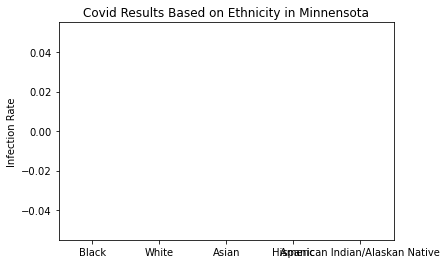

In [12]:
#find quartiles and upper, lower bound, outliers

def outliers(results):
    new_covid_df = cdc_df.loc[cdc_df['Infection Status'] == results]['Race']
    quartiles = new_covid_df.quantile([.25,.5,.75])
    lowerq = quartiles[0.25]
    upperq = quartiles[0.75]
    iqr = upperq - lowerq
    lower_bound = lowerq - (1.5 * iqr)
    upper_bound = upperq + (1.5 * iqr)
    outliers = new_covid_df.loc[(new_covid_df < lower_bound) | (new_covid_df > upper_bound)]
    print(outliers)
    return new_covid_df


race_1 = outliers('Black')
race_2 = outliers('White')
race_3 = outliers('Asian')
race_4 = outliers('Hispanic')
race_5 = outliers('American Indian/Alaskan Native')

plt.boxplot([race_1, race_2, race_3, race_4, race_5], labels=['Black','White','Asian','Hispanic', 'American Indian/Alaskan Native'])
plt.ylabel("Infection Rate")
plt.title('Covid Results Based on Ethnicity in Minnensota')

plt.tight_layout
plt.show()
